In [ ]:
import numpy as np
from sklearn.decomposition import NMF

# 生成一个随机的非负矩阵
V = np.array([[1, 2, 64], 
              [2, 2, 14], 
              [3, 3, 24], 
              [2, 2, 34], 
              [7, 3, 4]])

# 使用 sklearn 库中的 NMF 模型进行分解
model = NMF(n_components=5, init='random', random_state=0)
W = model.fit_transform(V)
H = model.components_

# 计算重构误差
reconstruction_error = np.linalg.norm(V - W @ H)

# 打印结果
print("原始矩阵 V:\n", V)
print("分解后的矩阵 W:\n", W)
print("分解后的矩阵 H:\n", H)
print("重构误差:", reconstruction_error)


In [108]:
adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')
adata_C = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_C_data.h5ad')

In [189]:
ctrl_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')


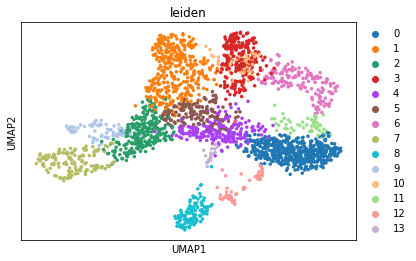

In [3]:
sc.pl.umap(adata_A, color=['leiden'])

In [5]:
adata_A.obs['x'] = adata_A.obsm['spatial'].T[0]
adata_A.obs['y'] = adata_A.obsm['spatial'].T[1]

In [72]:
from scipy.signal import convolve
from scipy.signal import convolve2d
from scipy.sparse import csr_matrix
from tqdm import tqdm

def get_3D_matrix(adata):
    x_max = int(adata.obs['x'].max())
    y_max = int(adata.obs['y'].max())
    # the spatial coordinates should be in adata.obs
    threeD_array = np.zeros((int(x_max), int(y_max), int(adata.var.shape[0])))
    print('Transfer anndate to 3D matrix...')
    for spot in tqdm(adata, bar_format='{l_bar}{bar:20}{r_bar}{percentage:3.0f}%'):
        x = int(spot.obs['x'])-1
        y = int(spot.obs['y'])-1
        threeD_array[x, y] = spot.X.toarray()
    return threeD_array


def convolve(array):
    kernel_A = np.array([[-1, -1, -1, -1, -1],
                         [-1,  2,  2,  2, -1],
                         [-1,  2,  8,  2, -1],
                         [-1,  2,  2,  2, -1],
                         [-1, -1, -1, -1, -1]])

    kernel_B = np.array([[0, -1, 0],
                         [-1, 5, -1],
                         [0, -1, 0]])

    n, m, k = array.shape
    # convolve each 2D layer
    output_array = np.zeros((n, m, k))
    print('Convolve each 2D layer...')
    for i in tqdm(range(k), bar_format='{l_bar}{bar:20}{r_bar}{percentage:3.0f}%'):
        output_array[:, :, i] = convolve2d(array[:, :, i], kernel_A, mode='same')
    output_array = np.where(output_array < 0, 0, output_array)
    return output_array


def update_anndata(array, adata):
    print('Update anndata...')
    for spot in tqdm(adata, bar_format='{l_bar}{bar:20}{r_bar}{percentage:3.0f}%'):
        x = int(spot.obs['x'])-1
        y = int(spot.obs['y'])-1
        spot.X = csr_matrix(array[x, y])
    

In [69]:
result = convolve(get_3D_matrix(adata_A))

100%|████████████████████| 32268/32268 [01:31<00:00, 353.19it/s]100%


In [73]:
update_anndata(result, adata_A)

Update anndata...


 59%|███████████▊        | 1431/2425 [17:47<08:04,  2.05it/s] 59% f:\conda\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|████████████████████| 2425/2425 [28:06<00:00,  1.44it/s]100%


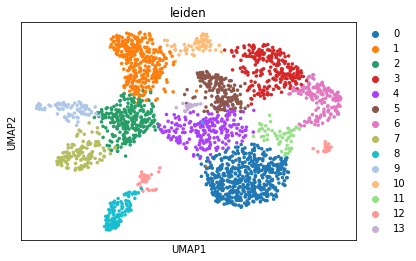

In [88]:
sc.tl.pca(adata_A, svd_solver='arpack')
sc.tl.umap(adata_A)
sc.tl.leiden(adata_A)
sc.pl.umap(adata_A, color=['leiden'])

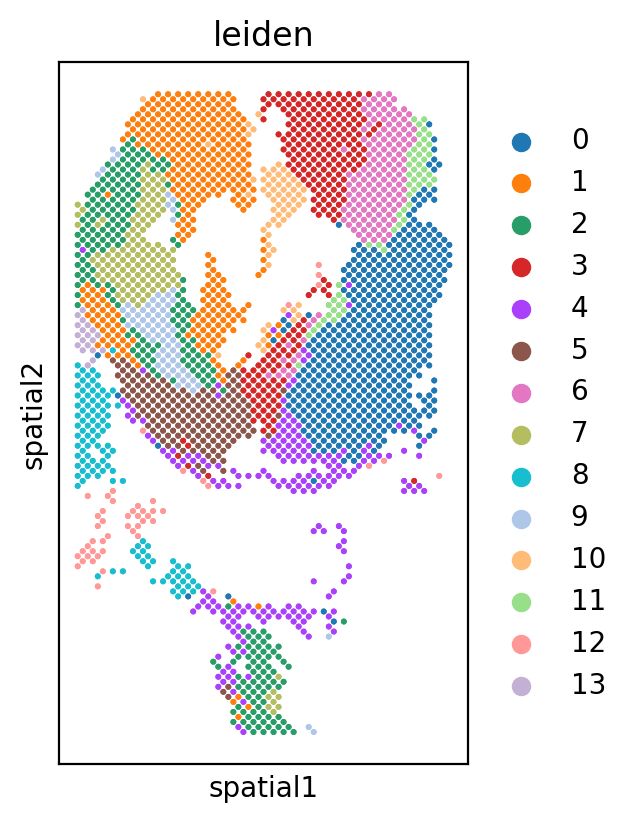

In [130]:
import squidpy as sq
sq.pl.spatial_scatter(adata_A, shape=None, color="leiden", size=5, dpi=200)

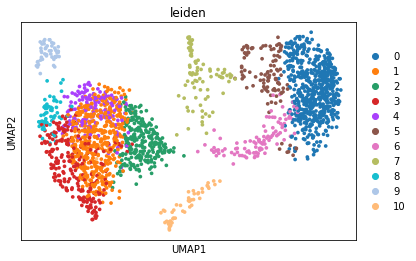

In [92]:
sc.pl.umap(adata_B, color=['leiden'])

In [94]:
adata_B.obs['x'] = adata_B.obsm['spatial'].T[0]
adata_B.obs['y'] = adata_B.obsm['spatial'].T[1]
result_B = convolve(get_3D_matrix(adata_B))
update_anndata(result_B, adata_B)

Transfer anndate to 3D matrix...


100%|████████████████████| 2179/2179 [00:16<00:00, 132.55it/s]100%


Convolve each 2D layer...


100%|████████████████████| 32268/32268 [01:04<00:00, 503.05it/s]100%


Update anndata...


 95%|███████████████████ | 2080/2179 [45:43<02:06,  1.28s/it] 95%f:\conda\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|████████████████████| 2179/2179 [48:10<00:00,  1.33s/it]100%


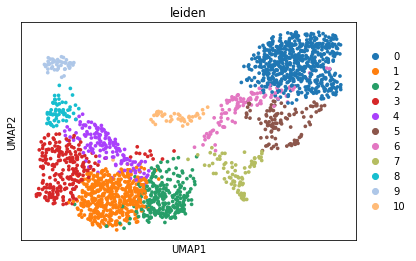

In [95]:
sc.tl.pca(adata_B, svd_solver='arpack')
sc.tl.umap(adata_B)
sc.tl.leiden(adata_B)
sc.pl.umap(adata_B, color=['leiden'])

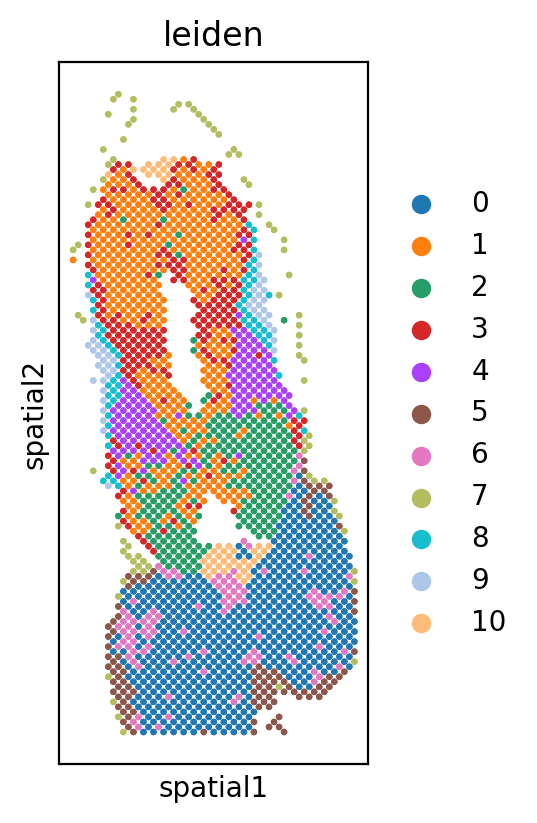

In [154]:
sq.pl.spatial_scatter(adata_B, shape=None, color="leiden", size=7, dpi=200, figsize=[3,4])

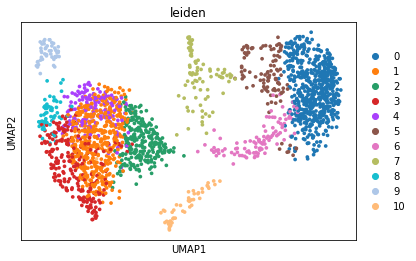

In [101]:
sc.pl.umap(ctrl, color=['leiden'])

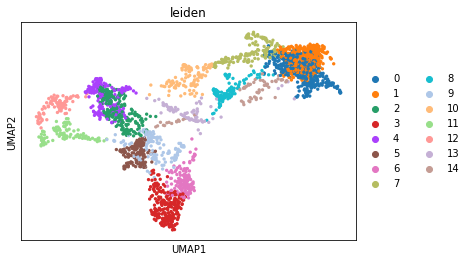

In [109]:
sc.pl.umap(adata_C, color=['leiden'])

In [110]:
adata_C.obs['x'] = adata_C.obsm['spatial'].T[0]
adata_C.obs['y'] = adata_C.obsm['spatial'].T[1]
result_C = convolve(get_3D_matrix(adata_C))
update_anndata(result_C, adata_C)

Transfer anndate to 3D matrix...


100%|████████████████████| 2677/2677 [00:24<00:00, 110.49it/s]100%


Convolve each 2D layer...


100%|████████████████████| 32268/32268 [01:25<00:00, 379.60it/s]100%


Update anndata...


  0%|                    | 0/2677 [00:00<?, ?it/s]  0%f:\conda\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|████████████████████| 2677/2677 [04:17<00:00, 10.41it/s]100%


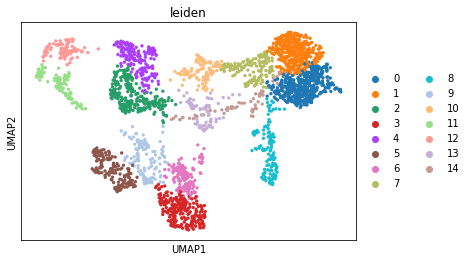

In [111]:
sc.tl.pca(adata_C, svd_solver='arpack')
sc.tl.umap(adata_C)
sc.tl.leiden(adata_C)
sc.pl.umap(adata_C, color=['leiden'])

In [118]:
sc.tl.pca(adata_C, svd_solver='arpack')
sc.tl.leiden(adata_C, key_added='test')
sc.tl.umap(adata_C)

In [134]:
sq.gr.spatial_neighbors(adata_B)

In [137]:
adata_B

AnnData object with n_obs × n_vars = 2179 × 32268
    obs: 'col_0', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_pixel', 'spatial_real'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [138]:
sq.gr.nhood_enrichment(adata_B, cluster_key="leiden")

  0%|          | 0/1000 [00:00<?, ?/s]

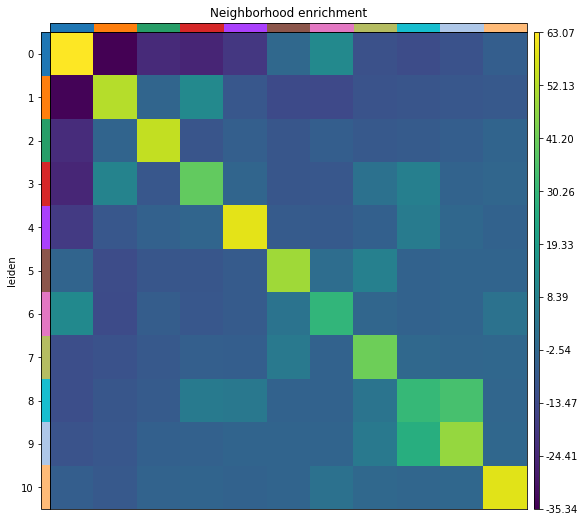

In [141]:
sq.pl.nhood_enrichment(adata_B, cluster_key="leiden")

In [182]:
import seaborn as sns

In [ ]:
# TODO:画表达量高的基因的热图
sns.heatmap()


f:\conda\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


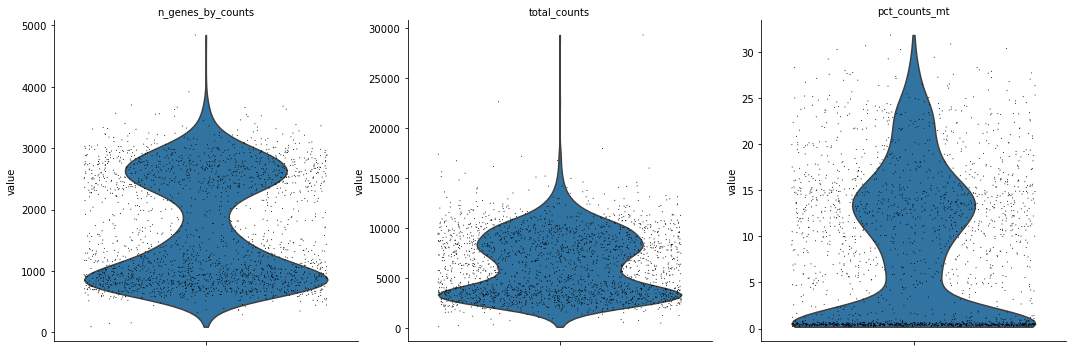

In [27]:
from util import *

adata = sc.read_10x_h5('E://human/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5')
add_spatial_position(adata, 'E://human/GSM4838132_Visium_Sample_B_tissue_positions_list.csv')
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

#sc.pp.filter_genes(adata, min_cells=2)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.var_names_make_unique()
sc.pl.violin(adata, 
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [8]:
adata

AnnData object with n_obs × n_vars = 2179 × 32268
    obs: 'x', 'y', 'fig_x', 'fig_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'
    obsm: 'spatial'

In [516]:
result = convolve(get_3D_matrix(adata))
update_anndata(result, adata)

Transfer anndate to 3D matrix...


100%|████████████████████| 2179/2179 [00:16<00:00, 135.73it/s]100%


Convolve each 2D layer...


100%|████████████████████| 32268/32268 [01:16<00:00, 424.52it/s]100%


Update anndata...


  0%|                    | 0/2179 [00:00<?, ?it/s]  0%f:\conda\lib\site-packages\scipy\sparse\_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|████████████████████| 2179/2179 [02:57<00:00, 12.27it/s]100%


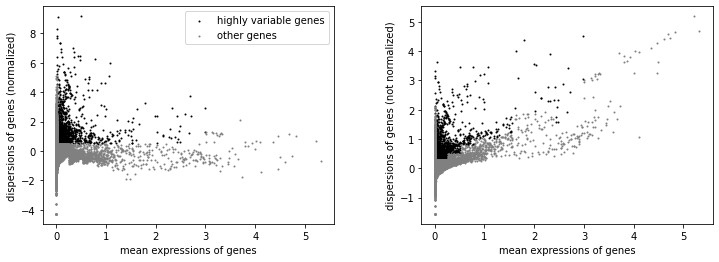

In [28]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [500]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

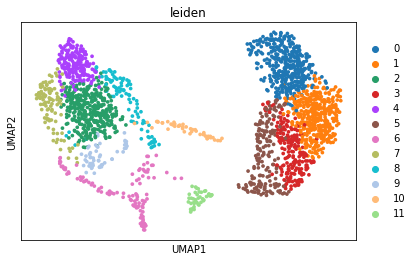

In [29]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

In [533]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')


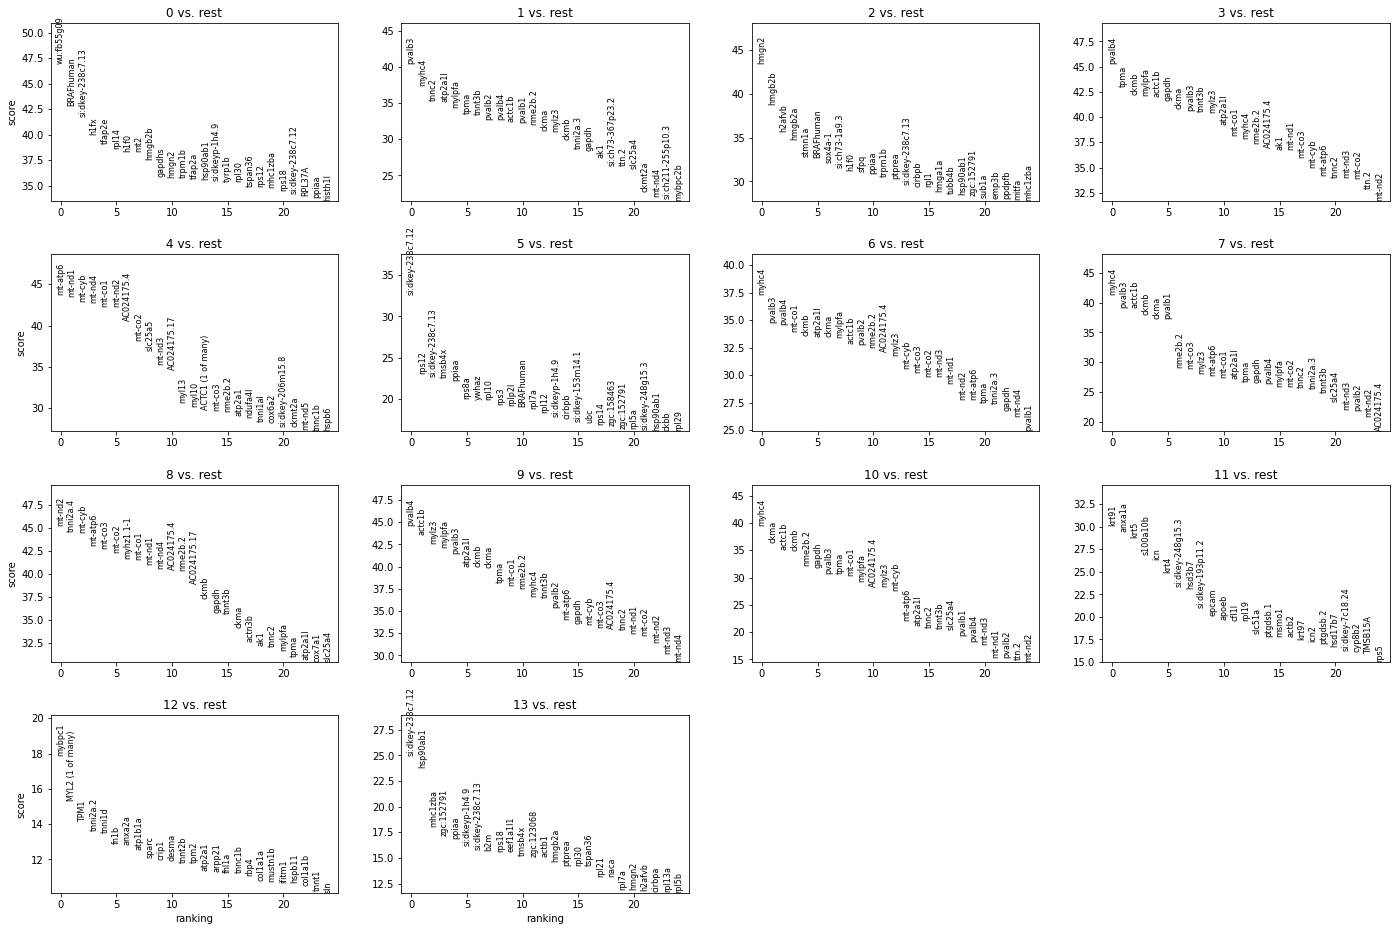

In [532]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, dpi=800)

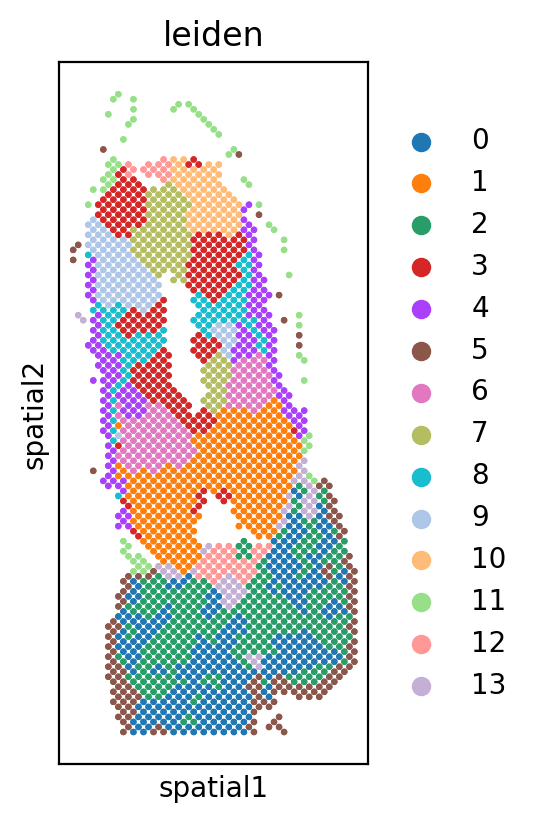

In [540]:
adata.uns.pop('leiden_colors')
sq.pl.spatial_scatter(adata, shape=None, color="leiden", size=7, dpi=200, img=img)

In [61]:
import tifffile as tiff
import numpy as np
import squidpy as sq
img = tiff.imread('E:/human/GSM4838131_Visium_A_image.tif')
img = img[:,:,:3]
img = np.rot90(img, k=1)

In [59]:
spatial_key = "spatial"
library_id = "tissue"
adata.uns[spatial_key] = {library_id: {}}
adata.uns[spatial_key][library_id]["images"] = {}
adata.uns[spatial_key][library_id]["images"] = {"hires": img}
adata.uns[spatial_key][library_id]["scalefactors"] = {"tissue_hires_scalef": 1, "spot_diameter_fullres": 89}

In [62]:
sq.pl.spatial_scatter(adata, color="leiden", dpi=500, size=3)

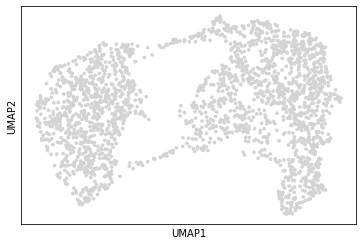

In [517]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata)

In [518]:
sc.tl.leiden(adata)

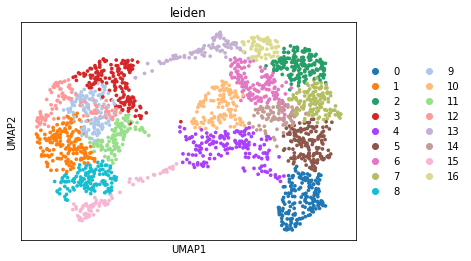

In [519]:
sc.pl.umap(adata, color='leiden')

In [447]:
result = convolve(get_3D_matrix(adata_A))
update_anndata(result, adata_A)

AnnData object with n_obs × n_vars = 2179 × 32268
    obs: 'col_0', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap', 'leiden_nhood_enrichment', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_pixel', 'spatial_real'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'